In [1]:
# Install required packages
!pip install -q kaggle
!pip install -q opencv-python
!pip install -q torch torchvision
!pip install -q fastapi
!pip install -q python-multipart
!pip install -q nest-asyncio
!pip install -q pyngrok

# For running FastAPI in Colab
!pip install -q uvicorn

print("All packages installed successfully!")

All packages installed successfully!


In [2]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print(f"GPU is available! Device: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available. Using CPU. Training will be very slow.")

GPU is available! Device: NVIDIA A100-SXM4-40GB


In [3]:
# This cell will handle the Kaggle API setup and dataset download

import os
import zipfile
from google.colab import files

# Create the kaggle directory and set permissions
!mkdir -p ~/.kaggle

# Upload your kaggle.json API key
print("Please upload your 'kaggle.json' API key file:")
uploaded = files.upload()

# Move the key to the proper location and set permissions
for fn in uploaded.keys():
    if fn == 'kaggle.json':
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        print("Kaggle API key configured successfully!")
    else:
        print(f"Ignoring {fn} - please make sure to upload kaggle.json")

# Download the dataset
!kaggle datasets download -d kshitizbhargava/deepfake-face-images

# Unzip the dataset
with zipfile.ZipFile('deepfake-face-images.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

print("Dataset downloaded and extracted successfully!")
print("Contents of the data directory:")
!ls -la data/

Please upload your 'kaggle.json' API key file:


Saving kaggle.json to kaggle.json
Kaggle API key configured successfully!
Dataset URL: https://www.kaggle.com/datasets/kshitizbhargava/deepfake-face-images
License(s): MIT
 54% 132M/244M [00:00<00:00, 1.38GB/s]
100% 244M/244M [00:00<00:00, 1.37GB/s]
Dataset downloaded and extracted successfully!
Contents of the data directory:
total 12
drwxr-xr-x 3 root root 4096 Sep 21 09:59  .
drwxr-xr-x 1 root root 4096 Sep 21 09:59  ..
drwxr-xr-x 4 root root 4096 Sep 21 09:59 'Final Dataset'


Contents of 'Final Dataset':
  Real
  Fake
  dataset.csv

Real images: 5890 files
Fake images: 7000 files


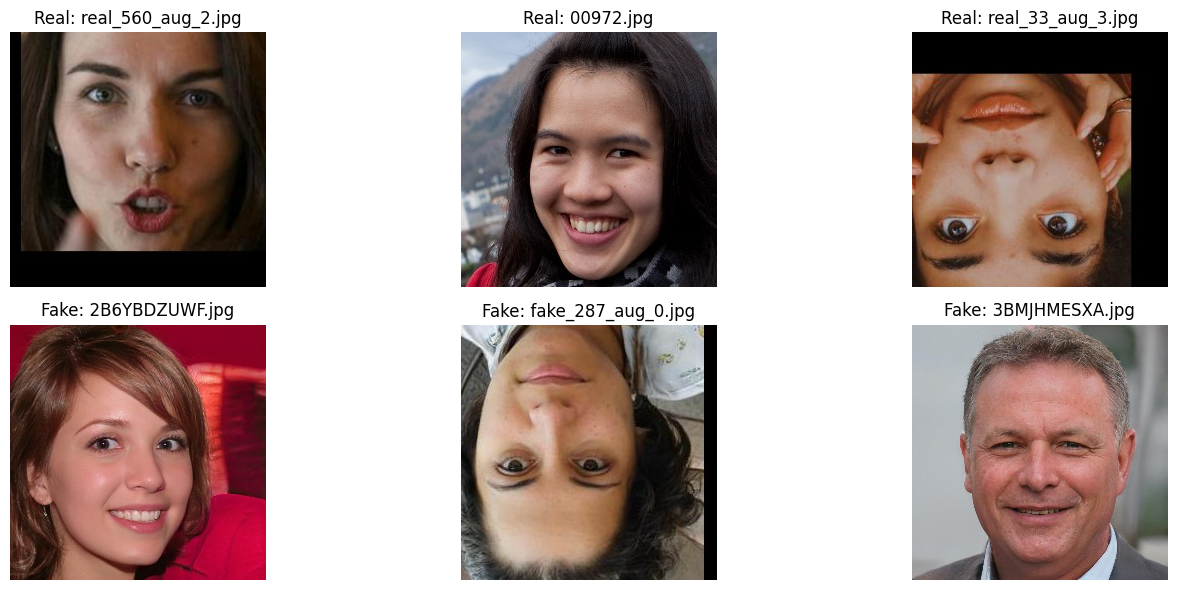

In [4]:
# Explore the dataset structure
import os
from pathlib import Path

data_dir = Path('data/Final Dataset')
print("Contents of 'Final Dataset':")
for item in data_dir.iterdir():
    print(f"  {item.name}")

# Check what's inside the main directories
real_dir = data_dir / 'Real'
fake_dir = data_dir / 'Fake'

print(f"\nReal images: {len(list(real_dir.glob('*.jpg')))} files")
print(f"Fake images: {len(list(fake_dir.glob('*.jpg')))} files")

# Let's see a sample of the images
import matplotlib.pyplot as plt
import random

def show_sample_images(real_path, fake_path, num_samples=3):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    # Show real images
    real_images = list(real_path.glob('*.jpg'))
    sample_real = random.sample(real_images, num_samples)
    for i, img_path in enumerate(sample_real):
        img = plt.imread(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Real: {img_path.name}")
        axes[0, i].axis('off')

    # Show fake images
    fake_images = list(fake_path.glob('*.jpg'))
    sample_fake = random.sample(fake_images, num_samples)
    for i, img_path in enumerate(sample_fake):
        img = plt.imread(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Fake: {img_path.name}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

show_sample_images(real_dir, fake_dir)

Total real images: 5890
Total fake images: 7000

Dataset split completed:
train: 4123 real, 4900 fake images
val: 883 real, 1050 fake images
test: 884 real, 1050 fake images


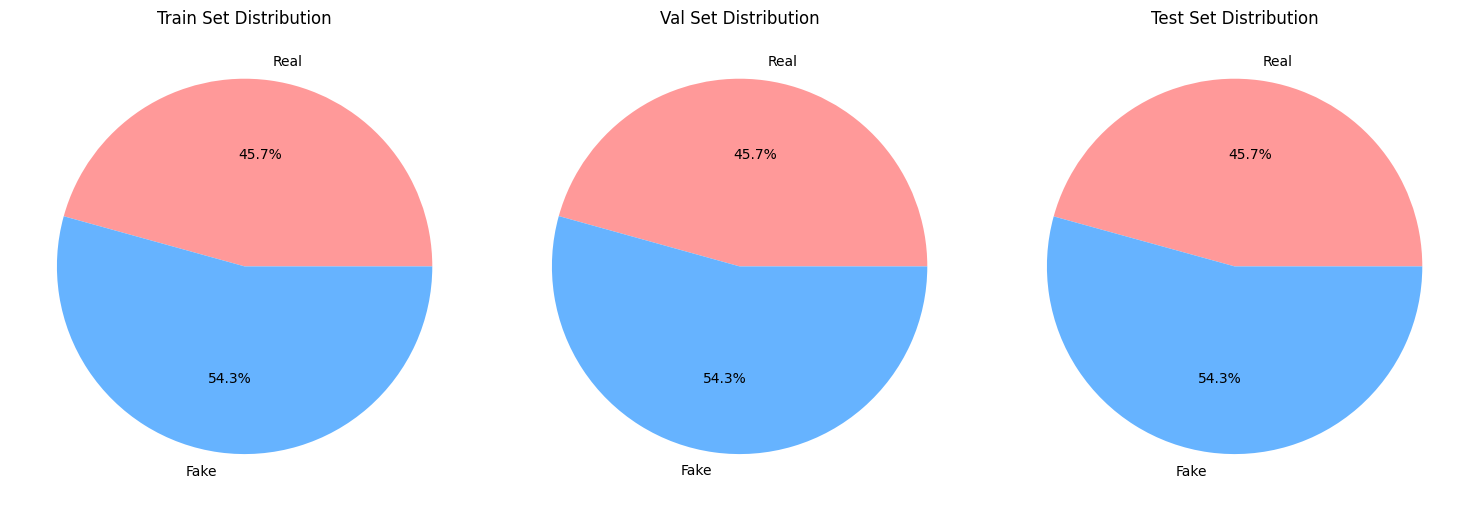

In [5]:
# Create directory structure for organized dataset
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = 'organized_data'
os.makedirs(base_dir, exist_ok=True)

# Create subdirectories
for split in ['train', 'val', 'test']:
    for category in ['real', 'fake']:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# Get lists of all image files
real_images = list((data_dir / 'Real').glob('*.jpg'))
fake_images = list((data_dir / 'Fake').glob('*.jpg'))

print(f"Total real images: {len(real_images)}")
print(f"Total fake images: {len(fake_images)}")

# Split real images: 70% train, 15% val, 15% test
real_train, real_temp = train_test_split(real_images, test_size=0.3, random_state=42)
real_val, real_test = train_test_split(real_temp, test_size=0.5, random_state=42)

# Split fake images: 70% train, 15% val, 15% test
fake_train, fake_temp = train_test_split(fake_images, test_size=0.3, random_state=42)
fake_val, fake_test = train_test_split(fake_temp, test_size=0.5, random_state=42)

# Function to copy images to their respective directories
def copy_images(image_list, destination_dir):
    for img_path in image_list:
        shutil.copy2(img_path, destination_dir)

# Copy real images
copy_images(real_train, os.path.join(base_dir, 'train', 'real'))
copy_images(real_val, os.path.join(base_dir, 'val', 'real'))
copy_images(real_test, os.path.join(base_dir, 'test', 'real'))

# Copy fake images
copy_images(fake_train, os.path.join(base_dir, 'train', 'fake'))
copy_images(fake_val, os.path.join(base_dir, 'val', 'fake'))
copy_images(fake_test, os.path.join(base_dir, 'test', 'fake'))

# Verify the splits
print("\nDataset split completed:")
for split in ['train', 'val', 'test']:
    real_count = len(os.listdir(os.path.join(base_dir, split, 'real')))
    fake_count = len(os.listdir(os.path.join(base_dir, split, 'fake')))
    print(f"{split}: {real_count} real, {fake_count} fake images")

# Show class distribution
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

splits = ['train', 'val', 'test']
colors = ['#ff9999', '#66b3ff']

for i, split in enumerate(splits):
    real_count = len(os.listdir(os.path.join(base_dir, split, 'real')))
    fake_count = len(os.listdir(os.path.join(base_dir, split, 'fake')))

    ax[i].pie([real_count, fake_count], labels=['Real', 'Fake'], autopct='%1.1f%%', colors=colors)
    ax[i].set_title(f'{split.capitalize()} Set Distribution')

plt.tight_layout()
plt.show()

Starting training...
 Epoch  |  Train Loss  |  Val Loss  | Train Acc | Val Acc |   Time   
-----------------------------------------------------------------
   1    |    0.5050    |   0.4256   |  0.7513   | 0.8024  |   27.00  
   2    |    0.4377    |   0.3760   |  0.7984   | 0.8443  |   25.66  
   3    |    0.4282    |   0.3602   |  0.8000   | 0.8458  |   25.86  
   4    |    0.4201    |   0.3603   |  0.8058   | 0.8453  |   25.82  
   5    |    0.4126    |   0.3478   |  0.8082   | 0.8495  |   25.83  
   6    |    0.4000    |   0.3537   |  0.8184   | 0.8510  |   25.45  
   7    |    0.3968    |   0.3487   |  0.8225   | 0.8515  |   25.61  
   8    |    0.3979    |   0.3523   |  0.8151   | 0.8474  |   25.93  
Training completed!


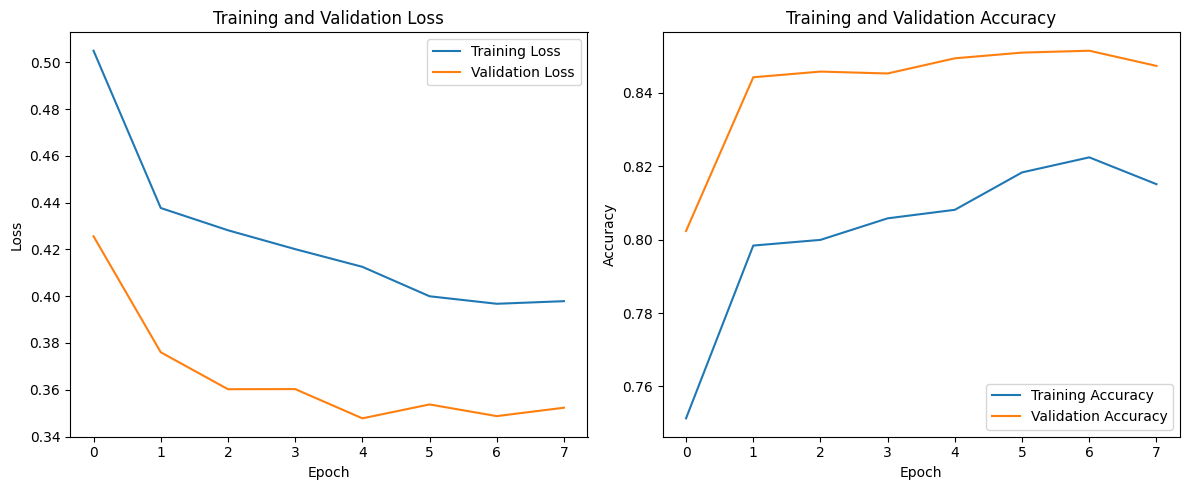

Model saved as 'deepfake_detection_model.pth'


In [7]:
# Training loop implementation
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize lists to track metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Number of epochs
num_epochs = 8

print("Starting training...")
print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Train Acc':^9} | {'Val Acc':^7} | {'Time':^9}")
print("-" * 65)

for epoch in range(num_epochs):
    start_time = time.time()

    # Training phase
    model.train()
    running_loss = 0.0
    train_preds = []
    train_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item() * images.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate training metrics
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = accuracy_score(train_labels, train_preds)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)

            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = accuracy_score(val_labels, val_preds)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    # Update learning rate
    scheduler.step()

    # Calculate epoch time
    epoch_time = time.time() - start_time

    # Print progress
    print(f"{epoch+1:^7} | {epoch_train_loss:^12.4f} | {epoch_val_loss:^10.4f} | {epoch_train_acc:^9.4f} | {epoch_val_acc:^7.4f} | {epoch_time:^9.2f}")

print("Training completed!")

# Plot training history
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save the trained model
torch.save(model.state_dict(), 'deepfake_detection_model.pth')
print("Model saved as 'deepfake_detection_model.pth'")

In [8]:
!pip install -q onnx
!pip install -q onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.1 MB/s eta 0:00:00


Test Accuracy: 0.8402
Test Precision: 0.8880
Test Recall: 0.7443
Test F1 Score: 0.8098


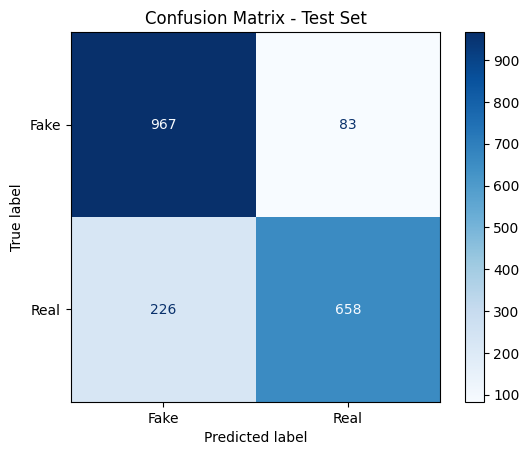

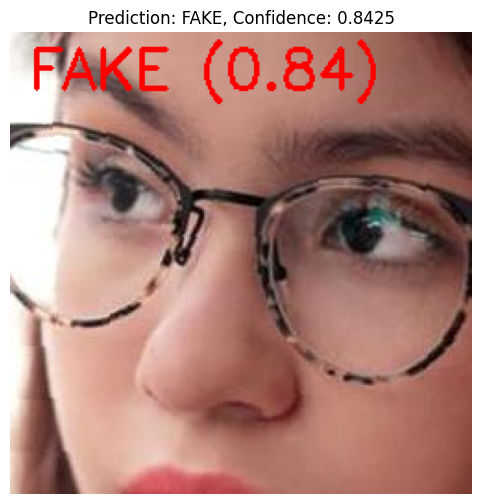

Image: real_489_aug_4.jpg
Prediction: FAKE
Confidence: 0.8425
Fake Probability: 0.8425
Model saved as 'deepfake_detector_model.pth'


/tmp/ipython-input-1829168841.py:115: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model,


Model exported to ONNX format: 'deepfake_detector.onnx'


In [11]:
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import glob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model on the test set
model.eval()
test_preds = []
test_labels = []
test_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).squeeze()
        probs = torch.sigmoid(outputs)
        preds = probs > 0.5

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

# Calculate test metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Create a function for frame-by-frame inference
def predict_frame(frame, model, device):
    """
    Process a single frame and return prediction and confidence
    """
    # Preprocess the frame
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Apply transformations
    input_tensor = transform(frame).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor).squeeze()
        prob_fake = torch.sigmoid(output).item()

    # Determine label and confidence
    is_fake = prob_fake > 0.5
    label = "FAKE" if is_fake else "REAL"
    confidence = prob_fake if is_fake else (1 - prob_fake)

    return label, confidence, prob_fake

# Find a valid sample image from our dataset
sample_images = glob.glob('organized_data/test/real/*.jpg') + glob.glob('organized_data/test/fake/*.jpg')

if sample_images:
    # Use the first available sample image
    sample_image_path = sample_images[0]
    sample_image = cv2.imread(sample_image_path)

    # Make prediction
    label, confidence, prob_fake = predict_frame(sample_image, model, device)

    # Display the result
    display_image = sample_image.copy()
    color = (0, 0, 255) if label == "FAKE" else (0, 255, 0)
    cv2.putText(display_image, f"{label} ({confidence:.2f})", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Convert BGR to RGB for proper display in Colab
    display_image_rgb = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB)

    # Display image and prediction
    plt.figure(figsize=(10, 6))
    plt.imshow(display_image_rgb)
    plt.axis('off')
    plt.title(f"Prediction: {label}, Confidence: {confidence:.4f}")
    plt.show()

    print(f"Image: {sample_image_path.split('/')[-1]}")
    print(f"Prediction: {label}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Fake Probability: {prob_fake:.4f}")
else:
    print("No sample images found in test directory.")

# Save the model for future use
torch.save(model.state_dict(), 'deepfake_detector_model.pth')
print("Model saved as 'deepfake_detector_model.pth'")

# Create a dummy input for ONNX export
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX with updated method
try:
    # Try the new export method for PyTorch 2.0+
    torch.onnx.export(model,
                      dummy_input,
                      "deepfake_detector.onnx",
                      input_names=['input'],
                      output_names=['output'],
                      dynamic_axes={'input': {0: 'batch_size'},
                                   'output': {0: 'batch_size'}},
                      opset_version=14)
    print("Model exported to ONNX format: 'deepfake_detector.onnx'")
except Exception as e:
    print(f"Error exporting to ONNX: {e}")
    print("Falling back to legacy export method...")
    # Fallback to legacy method
    torch.onnx.export(model,
                      dummy_input,
                      "deepfake_detector.onnx",
                      input_names=['input'],
                      output_names=['output'],
                      dynamic_axes={'input': {0: 'batch_size'},
                                   'output': {0: 'batch_size'}})
    print("Model exported to ONNX format using legacy method: 'deepfake_detector.onnx'")

In [ ]:
#=====================================

In [2]:
!pip install -q mediapipe

In [ ]:
#======================USE THIS=======================

In [26]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
import numpy as np
import os

# --- Model Configuration ---
# XceptionNet expects images of size (299, 299)
IMG_HEIGHT = 299
IMG_WIDTH = 299

# --- Load the Pre-trained Base Model ---
# We load XceptionNet pre-trained on ImageNet.
# 'include_top=False' removes the final fully-connected layer that classifies 1000 ImageNet classes.
# This allows us to add our own output layer for deepfake detection.
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# --- Freeze the Base Model Layers ---
# We freeze the convolutional base to prevent its weights from being updated
# during the initial training phase. We will only train our new classification layers.
base_model.trainable = False

# --- Add a Custom Classification Head ---
# We'll add our own layers on top of the frozen base model.
x = base_model.output
x = GlobalAveragePooling2D()(x) # Flattens the feature map
x = Dense(1024, activation='relu')(x) # An intermediate dense layer
# The final output layer has one neuron with a sigmoid activation
# for binary classification (0 for 'real', 1 for 'fake').
predictions = Dense(1, activation='sigmoid')(x)

# --- Construct the Final Model ---
# This is the model we will train.
model = Model(inputs=base_model.input, outputs=predictions)

# --- Print the Model Summary ---
# This shows you the architecture of your new model.
print("Model architecture created successfully!")
model.summary()

Model architecture created successfully!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 74, 74,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add_12[0][0]    

 Total params: 22,960,681 (87.59 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [27]:
# This cell will handle the Kaggle API setup and dataset download

import os
import zipfile
from google.colab import files

# Create the kaggle directory and set permissions
!mkdir -p ~/.kaggle

# Upload your kaggle.json API key
print("Please upload your 'kaggle.json' API key file:")
uploaded = files.upload()

# Move the key to the proper location and set permissions
for fn in uploaded.keys():
    if fn == 'kaggle.json':
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        print("Kaggle API key configured successfully!")
    else:
        print(f"Ignoring {fn} - please make sure to upload kaggle.json")

# Download the dataset
!kaggle datasets download -d kshitizbhargava/deepfake-face-images

# Unzip the dataset
with zipfile.ZipFile('deepfake-face-images.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

print("Dataset downloaded and extracted successfully!")
print("Contents of the data directory:")
!ls -la data/

Please upload your 'kaggle.json' API key file:


Saving kaggle.json to kaggle.json
Kaggle API key configured successfully!
Dataset URL: https://www.kaggle.com/datasets/kshitizbhargava/deepfake-face-images
License(s): MIT
deepfake-face-images.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset downloaded and extracted successfully!
Contents of the data directory:
total 12
drwxr-xr-x 3 root root 4096 Sep 21 09:59  .
drwxr-xr-x 1 root root 4096 Sep 21 13:33  ..
drwxr-xr-x 4 root root 4096 Sep 21 09:59 'Final Dataset'


Contents of 'Final Dataset':
  Real
  Fake
  dataset.csv

Real images: 5890 files
Fake images: 7000 files


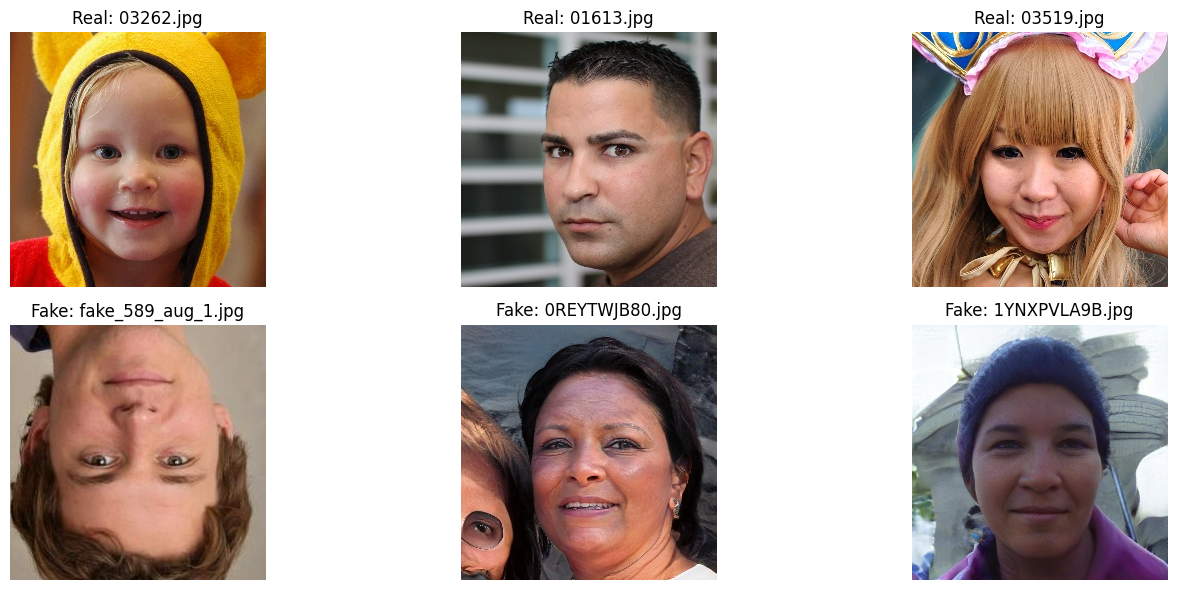

In [28]:
# Explore the dataset structure
import os
from pathlib import Path

data_dir = Path('data/Final Dataset')
print("Contents of 'Final Dataset':")
for item in data_dir.iterdir():
    print(f"  {item.name}")

# Check what's inside the main directories
real_dir = data_dir / 'Real'
fake_dir = data_dir / 'Fake'

print(f"\nReal images: {len(list(real_dir.glob('*.jpg')))} files")
print(f"Fake images: {len(list(fake_dir.glob('*.jpg')))} files")

# Let's see a sample of the images
import matplotlib.pyplot as plt
import random

def show_sample_images(real_path, fake_path, num_samples=3):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))

    # Show real images
    real_images = list(real_path.glob('*.jpg'))
    sample_real = random.sample(real_images, num_samples)
    for i, img_path in enumerate(sample_real):
        img = plt.imread(img_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Real: {img_path.name}")
        axes[0, i].axis('off')

    # Show fake images
    fake_images = list(fake_path.glob('*.jpg'))
    sample_fake = random.sample(fake_images, num_samples)
    for i, img_path in enumerate(sample_fake):
        img = plt.imread(img_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Fake: {img_path.name}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

show_sample_images(real_dir, fake_dir)

Total real images: 5890
Total fake images: 7000

Dataset split completed:
train: 4123 real, 4900 fake images
val: 883 real, 1050 fake images
test: 884 real, 1050 fake images


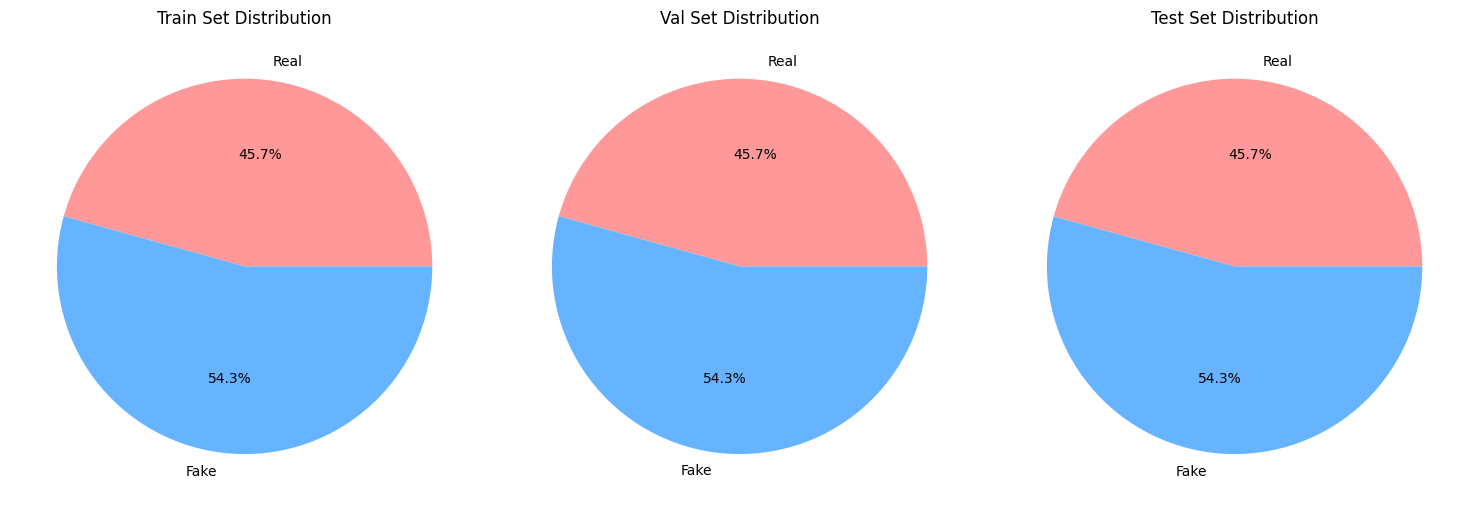

In [29]:
# Create directory structure for organized dataset
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = 'organized_data'
os.makedirs(base_dir, exist_ok=True)

# Create subdirectories
for split in ['train', 'val', 'test']:
    for category in ['real', 'fake']:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# Get lists of all image files
real_images = list((data_dir / 'Real').glob('*.jpg'))
fake_images = list((data_dir / 'Fake').glob('*.jpg'))

print(f"Total real images: {len(real_images)}")
print(f"Total fake images: {len(fake_images)}")

# Split real images: 70% train, 15% val, 15% test
real_train, real_temp = train_test_split(real_images, test_size=0.3, random_state=42)
real_val, real_test = train_test_split(real_temp, test_size=0.5, random_state=42)

# Split fake images: 70% train, 15% val, 15% test
fake_train, fake_temp = train_test_split(fake_images, test_size=0.3, random_state=42)
fake_val, fake_test = train_test_split(fake_temp, test_size=0.5, random_state=42)

# Function to copy images to their respective directories
def copy_images(image_list, destination_dir):
    for img_path in image_list:
        shutil.copy2(img_path, destination_dir)

# Copy real images
copy_images(real_train, os.path.join(base_dir, 'train', 'real'))
copy_images(real_val, os.path.join(base_dir, 'val', 'real'))
copy_images(real_test, os.path.join(base_dir, 'test', 'real'))

# Copy fake images
copy_images(fake_train, os.path.join(base_dir, 'train', 'fake'))
copy_images(fake_val, os.path.join(base_dir, 'val', 'fake'))
copy_images(fake_test, os.path.join(base_dir, 'test', 'fake'))

# Verify the splits
print("\nDataset split completed:")
for split in ['train', 'val', 'test']:
    real_count = len(os.listdir(os.path.join(base_dir, split, 'real')))
    fake_count = len(os.listdir(os.path.join(base_dir, split, 'fake')))
    print(f"{split}: {real_count} real, {fake_count} fake images")

# Show class distribution
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

splits = ['train', 'val', 'test']
colors = ['#ff9999', '#66b3ff']

for i, split in enumerate(splits):
    real_count = len(os.listdir(os.path.join(base_dir, split, 'real')))
    fake_count = len(os.listdir(os.path.join(base_dir, split, 'fake')))

    ax[i].pie([real_count, fake_count], labels=['Real', 'Fake'], autopct='%1.1f%%', colors=colors)
    ax[i].set_title(f'{split.capitalize()} Set Distribution')

plt.tight_layout()
plt.show()

In [23]:
!pip install -q tensorflow

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Define Paths ---
train_dir = 'organized_data/train'
val_dir = 'organized_data/val'
# test_dir is ready for final evaluation later
test_dir = 'organized_data/test'

# --- Set Up Data Generators ---
# Create a generator for training data (with data augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,      # Normalize pixel values
    rotation_range=20,   # Randomly rotate images
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a generator for validation data (only rescaling)
# We don't augment validation data to get a true measure of performance.
val_datagen = ImageDataGenerator(rescale=1./255)

# --- Create the Generators from Directories ---
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='binary'
)

print("\nData generators updated and ready for training!")

Found 9023 images belonging to 2 classes.
Found 1933 images belonging to 2 classes.

Data generators updated and ready for training!


In [31]:
from tensorflow.keras.optimizers import Adam

# --- 1. Compile the Model ---
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print("Model compiled successfully!")


# --- 2. Train the Model ---
EPOCHS = 10

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

print("\nModel training complete! 🎉")


# --- 3. Save the Trained Model ---
# This new section saves the entire model to a single file.
model_filename = 'deepfake_detector_model.keras'
model.save(model_filename)

print(f"\n✅ Model successfully saved to '{model_filename}'")

Model compiled successfully!


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 187s 633ms/step - accuracy: 0.7174 - loss: 0.5468 - val_accuracy: 0.7641 - val_loss: 0.4624
Epoch 2/10
  1/281 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.8125 - loss: 0.3957

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8125 - loss: 0.3957 - val_accuracy: 0.7677 - val_loss: 0.4537
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 171s 610ms/step - accuracy: 0.8034 - loss: 0.4049 - val_accuracy: 0.8417 - val_loss: 0.3361
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8438 - loss: 0.3259 - val_accuracy: 0.8453 - val_loss: 0.3350
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 171s 609ms/step - accuracy: 0.8274 - loss: 0.3594 - val_accuracy: 0.8307 - val_loss: 0.3544
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9062 - loss: 0.2247 - val_accuracy: 0.8266 - val_loss: 0.3552
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 170s 605ms/step - accuracy: 0.8286 - loss: 0.3555 - val_accuracy: 0.8333 - val_loss: 0.3473
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8750 - loss: 0.2905 - val_accuracy: 0.8432 - val_loss: 0.3361
Epoch 9/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 171s 609ms/step - accuracy: 0.8338 - loss: 0.3516 - val_acc

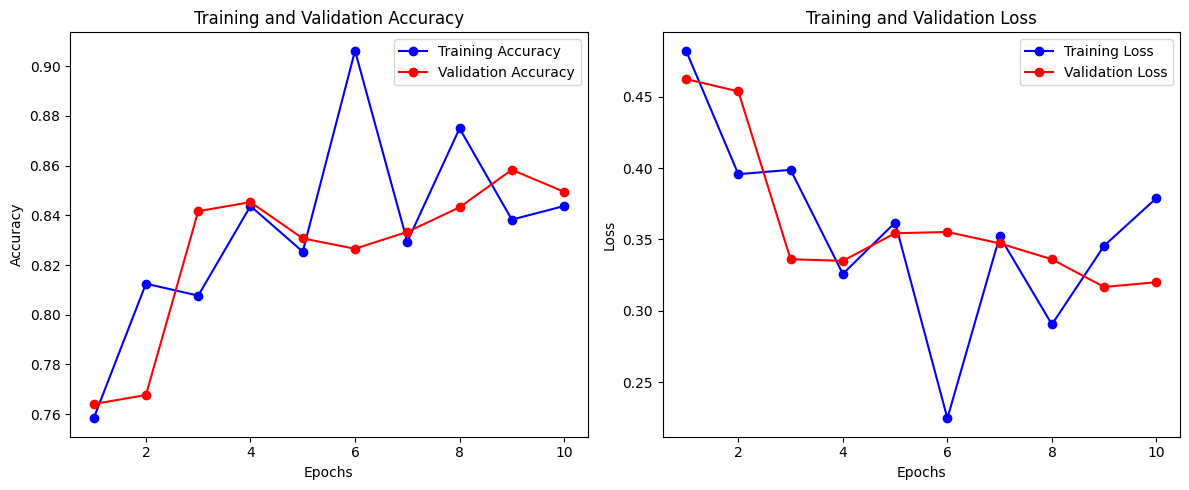

In [32]:
import matplotlib.pyplot as plt

# --- Get the training history ---
history_dict = history.history

# --- Plot Accuracy ---
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# --- Plot Loss ---
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# --- Create a generator for the test data ---
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'organized_data/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='binary',
    shuffle=False # No need to shuffle for evaluation
)

# --- Evaluate the model ---
print("\nEvaluating model on the test set...")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Found 1934 images belonging to 2 classes.

Evaluating model on the test set...
61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.7971 - loss: 0.4192
Test Accuracy: 86.09%
Test Loss: 0.3077


In [15]:
# main.py
import numpy as np
import tensorflow as tf
from fastapi import FastAPI, File, UploadFile
from PIL import Image
import io

# --- 1. Initialize the FastAPI App ---
app = FastAPI(
    title="Deepfake Detection API",
    description="An API to detect if a face image is a deepfake or real.",
    version="1.0.0",
)

# --- 2. Load the Trained Model ---
# Load the model once when the application starts
try:
    model = tf.keras.models.load_model('deepfake_detector_model.keras')
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    model = None

# --- 3. Define Image Preprocessing ---
def preprocess_image(image_bytes: bytes):
    """
    Preprocesses the image to the format expected by the model.
    - Resizes to (299, 299)
    - Normalizes pixel values to [0, 1]
    - Expands dimensions to create a batch of 1
    """
    img = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    img = img.resize((299, 299))
    img_array = np.array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    return img_array

# --- 4. Define the Prediction Endpoint ---
@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    """
    Receives an image file, preprocesses it, and returns the prediction.
    """
    if not model:
        return {"error": "Model is not loaded. Please check the server logs."}

    # Read the image file from the upload
    image_bytes = await file.read()

    # Preprocess the image
    processed_image = preprocess_image(image_bytes)

    # Make a prediction
    prediction = model.predict(processed_image)
    score = float(prediction[0][0])

    # Determine the label based on the score
    label = "Fake" if score > 0.5 else "Real"
    confidence = score if label == "Fake" else 1 - score

    return {
        "prediction": label,
        "confidence": f"{confidence:.4f}"
    }

# --- Optional: Add a root endpoint for simple health check ---
@app.get("/")
def read_root():
    return {"status": "Deepfake Detection API is running"}

❌ Error loading model: File not found: filepath=deepfake_detector_model.keras. Please ensure the file is an accessible `.keras` zip file.
